In [ ]:
!pip install -U opencv-python
!apt-get upgrade
!apt update && apt install -y libsm6 libxext6 ffmpeg libfontconfig1 libxrender1 libgl1-mesa-glx
!aws s3 cp s3://lowresolutionhighresolution/dataset/ . --recursive

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

print(np.__version__)
print(tf.__version__)
print(cv2.__version__)
# !pip install --upgrade tensorflow
# !pip install numpy --upgrade

1.18.5
2.1.3
4.5.1


In [2]:
def load_data(path):
    high_res_images = []
    low_res_images = []
    for dirname, _, filenames in os.walk(path+'high_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = process_image(img)
            high_res_images.append(img)
        
    for dirname, _, filenames_2 in os.walk(path+'low_res'):
        for filename in filenames_2:
            if filename in filenames: # check for non-present images
                img = cv2.imread(os.path.join(dirname, filename))
                img = process_image(img)
                low_res_images.append(img)
    
    # zero-mean and zero-center the standard deviations ....
    low_res_array = np.array(low_res_images)
    #mean_centered_low_res = (low_res_array - low_res_array.mean())/low_res_array.std()
    
    # zero-mean and zero-center the standard deviations .....
    high_res_array = np.array(high_res_images)
    #mean_centered_high_res = (high_res_array - high_res_array.mean())/high_res_array.std()
    
    
    #return mean_centered_low_res, mean_centered_high_res
    return low_res_array,high_res_array

def process_image(image):
    return image/255

In [ ]:
## The preprocessing of the images
def load_data(path):
    high_res_images = []
    low_res_images = []
    for dirname, _, filenames in os.walk(path+'low_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = process_image(img)
            low_res_images.append(img)
        
    for dirname, _, filenames in os.walk(path+'high_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = process_image(img)
            high_res_images.append(img)
    
    return np.array(low_res_images), np.array(high_res_images)

def process_image(image):
    return image/255

In [3]:
base_dir = ''
train_x, train_y =  load_data(base_dir+'train/')
val_x, val_y = load_data(base_dir+'val/')

In [4]:
train_x.shape

(684, 256, 256, 3)

In [5]:
train_y.shape

(684, 256, 256, 3)

In [6]:
val_x.shape

(170, 256, 256, 3)

In [7]:
val_y.shape

(170, 256, 256, 3)

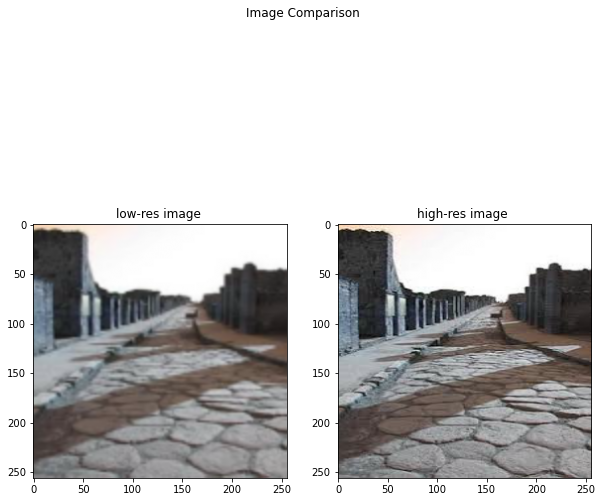

In [8]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
fig.suptitle('Image Comparison')
ax1.imshow(train_x[1])
ax1.title.set_text("low-res image ")
ax2.imshow(train_y[1])
ax2.title.set_text("high-res image ")

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l1)
    print('This is the l2\'s shape {}'.format(l2.shape))

    l3 = MaxPooling2D(padding='same')(l2)
    l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l4)
    print('This is L5 shape {}'.format(l5.shape))

    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l6)
    print('This is L7 shape {}'.format(l7.shape))
    #l8 = UpSampling2D()(l7)
    l8 = Conv2DTranspose(128,(1,1),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l7)
    # increasing the stide to 2,2 enables upsampling of the images
    print('This is L8 shape {}'.format(l8.shape))
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l9)

    l11 = add([l5, l10])
    
    print('This is the l11 shape {}'.format(l11.shape))
    #l12 = UpSampling2D()(l11)
    l12 = Conv2DTranspose(128,(2,2),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l11)
    
    print('This is the l12\'s shape {}'.format(l12.shape))
    
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l13)

    l15 = add([l14, l2])

    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10))(l15)


    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [ ]:
#with tf.device('/device:GPU:0'):
model = build_model()
train_x , train_y = train_x , train_y
val_x , val_y = val_x, val_y

In [ ]:
model.summary()

In [ ]:
def train(train_x, train_y, epochs = 1, batch_size = 14, shuffle = True):
    model.fit(train_x, train_y,epochs= epochs,batch_size=batch_size,shuffle=shuffle)

In [ ]:
train(train_x, train_y, epochs = 10, batch_size = 14, shuffle = True)

In [ ]:
predict_y = model.predict(val_x)
#plt.subplots(2,2,figsize=(15,15))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[11])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[11])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[11])
ax3.title.set_text("model's output")

# Model with Batch Normalization

In [9]:
## Model Number 2 with batch normalization to go one level deeper in expressiveness
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l1)
    print('This is the l2\'s shape {}'.format(l2.shape))

    l3 = MaxPooling2D(padding='same')(l2)
    l3 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l3)
    
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l4)
    print('This is L5 shape {}'.format(l5.shape))

    l6 = MaxPooling2D(padding='same')(l5)
    l6 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l6)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l6)
    print('This is L7 shape {}'.format(l7.shape))
    
    l8 = Conv2DTranspose(128,(1,1),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l7)
    # increasing the stide to 2,2 enables upsampling of the images
    print('This is L8 shape {}'.format(l8.shape))
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l9)

    l11 = add([l5, l10])
    
    print('This is the l11 shape {}'.format(l11.shape))
    #l12 = UpSampling2D()(l11)
    l12 = Conv2DTranspose(128,(2,2),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l11)
    
    print('This is the l12\'s shape {}'.format(l12.shape))
    
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l13)

    l15 = add([l14, l2])

    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10))(l15)


    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [10]:
#with tf.device('/device:GPU:0'):
model = build_model()
train_x , train_y = train_x , train_y
val_x , val_y = val_x, val_y


#build the model and sample the model
def train(train_x, train_y, epochs = 1, batch_size = 14, shuffle = True):
    model.fit(train_x, train_y,epochs= epochs,batch_size=batch_size,shuffle=shuffle)
    
# Run the inference of the model
train(train_x, train_y, epochs = 10, batch_size = 14, shuffle = True)

This is the l2's shape (None, 256, 256, 64)
This is L5 shape (None, 128, 128, 128)
This is L7 shape (None, 64, 64, 256)
This is L8 shape (None, 128, 128, 128)
This is the l11 shape (None, 128, 128, 128)
This is the l12's shape (None, 256, 256, 128)
Train on 684 samples
Epoch 1/10
684/684 [==============================] - 143s 210ms/sample - loss: 0.0259
Epoch 2/10
684/684 [==============================] - 141s 207ms/sample - loss: 0.0033
Epoch 3/10
684/684 [==============================] - 142s 207ms/sample - loss: 0.0024
Epoch 4/10
684/684 [==============================] - 142s 207ms/sample - loss: 0.0022
Epoch 5/10
684/684 [==============================] - 141s 206ms/sample - loss: 0.0020
Epoch 6/10
684/684 [==============================] - 142s 208ms/sample - loss: 0.0019
Epoch 7/10
684/684 [==============================] - 142s 208ms/sample - loss: 0.0019
Epoch 8/10
684/684 [==============================] - 142s 208ms/sample - loss: 0.0018
Epoch 9/10
684/684 [==============

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


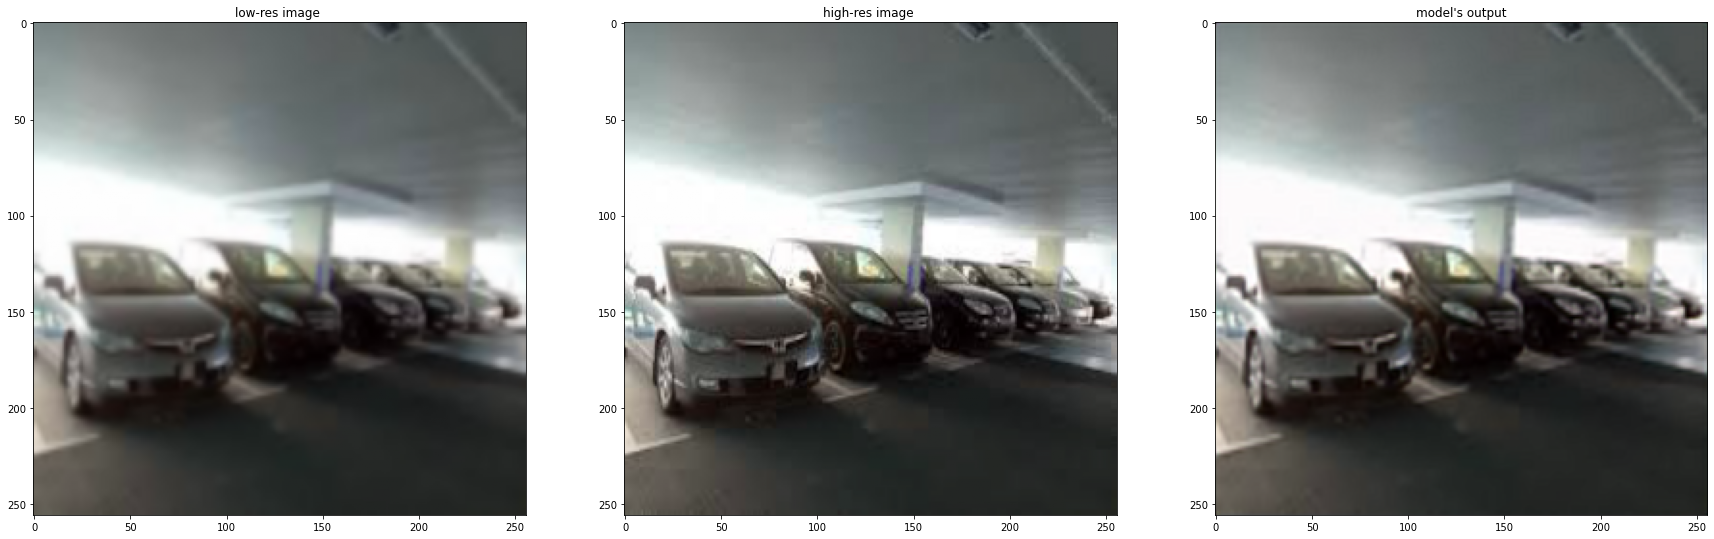

<Figure size 2880x2880 with 0 Axes>

In [11]:
predict_y = model.predict(val_x)
#plt.subplots(2,2,figsize=(15,15))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[11])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[11])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[11])
ax3.title.set_text("model's output")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


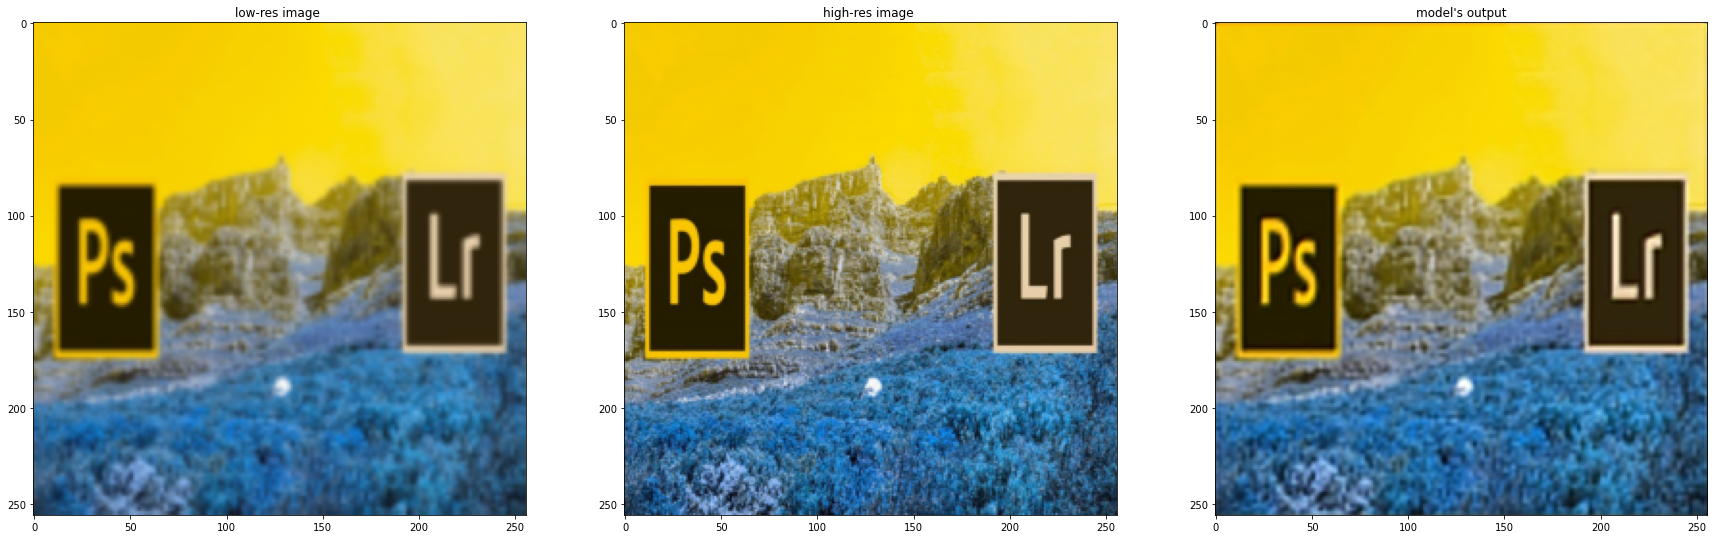

<Figure size 2880x2880 with 0 Axes>

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[25])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[25])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[25])
ax3.title.set_text("model's output")

# Deeper Model with batch-norm and deeper architecture 

In [14]:
## Model Number 3 with batch normalization to go 2 levels deeper in expressiveness
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l1)
    print('This is the l2\'s shape {}'.format(l2.shape))

    l3 = MaxPooling2D(padding='same')(l2)
    l3 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l3)
    
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l4)
    print('This is L5 shape {}'.format(l5.shape))

    l6 = MaxPooling2D(padding='same')(l5)
    l6 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l6)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l6) #256,64,64
    print('This is L7 shape {}'.format(l7.shape))
    
    # A few layers deeper into the convolution with more filters 
    l16 = Conv2D(512, (2,2), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l7) #512,64,64
    l17= MaxPooling2D(padding='same')(l16) #512,32,32
    l18 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l17)
    
    l19 = Conv2D(512, (2,2), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l18) #512,32,32
    
    #Upscaling the convolution layers
    l20 = Conv2DTranspose(256,(2,2),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l19) #256,64,64
    l21 = add([l7,l20])
    
    
    l8 = Conv2DTranspose(128,(1,1),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l21) #128,128,128
    # increasing the stide to 2,2 enables upsampling of the images
    print('This is L8 shape {}'.format(l8.shape))
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l9)

    l11 = add([l5, l10])
    
    print('This is the l11 shape {}'.format(l11.shape))
    #l12 = UpSampling2D()(l11)
    l12 = Conv2DTranspose(128,(2,2),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l11)
    
    print('This is the l12\'s shape {}'.format(l12.shape))
    
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l13)

    l15 = add([l14, l2])

    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10))(l15)


    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [15]:
#with tf.device('/device:GPU:0'):
model_2 = build_model()
train_x , train_y = train_x , train_y
val_x , val_y = val_x, val_y


#build the model and sample the model
def train(train_x, train_y, epochs = 1, batch_size = 14, shuffle = True):
    model_2.fit(train_x, train_y,epochs= epochs,batch_size=batch_size,shuffle=shuffle)
    
# Run the inference of the model
train(train_x, train_y, epochs = 10, batch_size = 14, shuffle = True)

This is the l2's shape (None, 256, 256, 64)
This is L5 shape (None, 128, 128, 128)
This is L7 shape (None, 64, 64, 256)
This is L8 shape (None, 128, 128, 128)
This is the l11 shape (None, 128, 128, 128)
This is the l12's shape (None, 256, 256, 128)
Train on 684 samples
Epoch 1/10
684/684 [==============================] - 166s 242ms/sample - loss: 0.0219
Epoch 2/10
684/684 [==============================] - 161s 236ms/sample - loss: 0.0029
Epoch 3/10
684/684 [==============================] - 163s 238ms/sample - loss: 0.0022
Epoch 4/10
684/684 [==============================] - 162s 237ms/sample - loss: 0.0019
Epoch 5/10
684/684 [==============================] - 162s 237ms/sample - loss: 0.0017
Epoch 6/10
684/684 [==============================] - 162s 237ms/sample - loss: 0.0016
Epoch 7/10
684/684 [==============================] - 162s 237ms/sample - loss: 0.0015
Epoch 8/10
684/684 [==============================] - 163s 238ms/sample - loss: 0.0015
Epoch 9/10
684/684 [==============

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


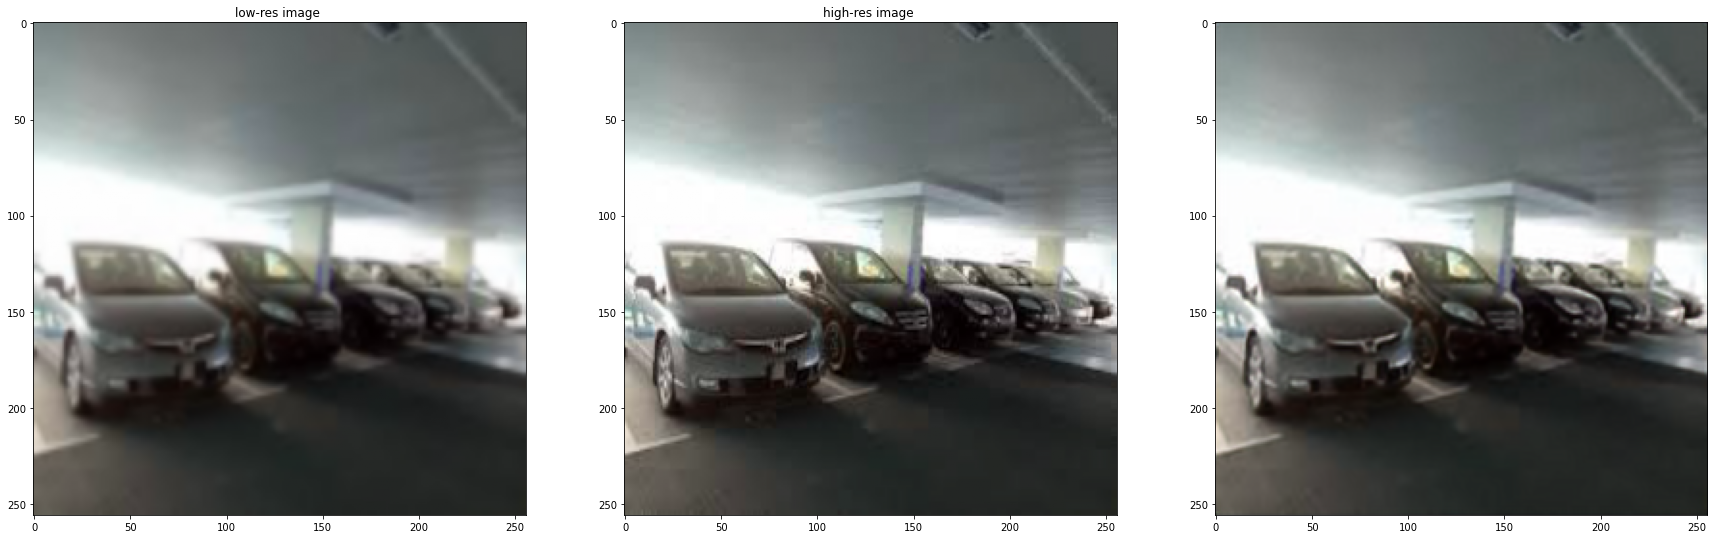

<Figure size 2880x2880 with 0 Axes>

In [16]:
predict_y = model_2.predict(val_x)
#plt.subplots(2,2,figsize=(15,15))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[11])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[11])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[11])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


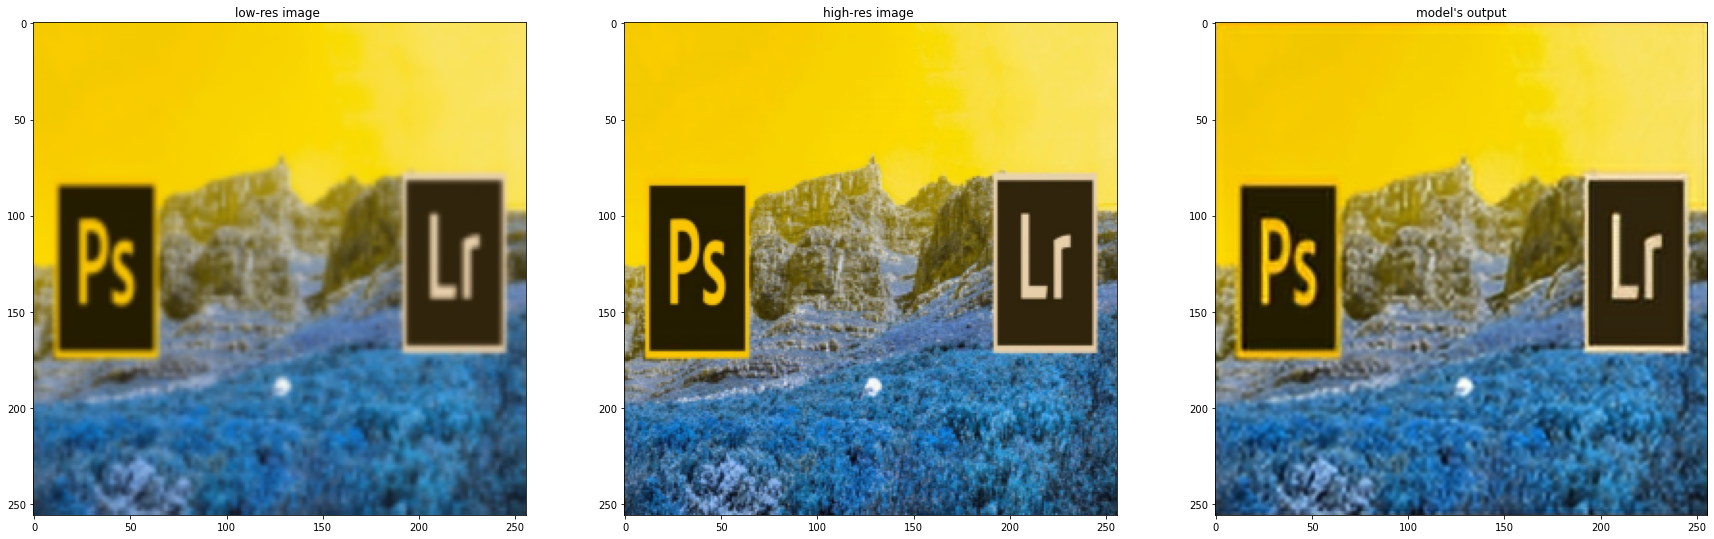

<Figure size 2880x2880 with 0 Axes>

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[25])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[25])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[25])
ax3.title.set_text("model's output")

## Exploring new data for use in the training process.....


In [19]:
!aws s3 cp s3://videoimagescartoon/Made_Folders/ . --recursive

download: s3://videoimagescartoon/Made_Folders/Train/.DS_Store to Train/.DS_Store      
download: s3://videoimagescartoon/Made_Folders/.DS_Store to ./.DS_Store                
download: s3://videoimagescartoon/Made_Folders/Train/high_res/.DS_Store to Train/high_res/.DS_Store
download: s3://videoimagescartoon/Made_Folders/Train/high_res/1000.jpg to Train/high_res/1000.jpg
download: s3://videoimagescartoon/Made_Folders/Train/high_res/1005.jpg to Train/high_res/1005.jpg
download: s3://videoimagescartoon/Made_Folders/Train/high_res/1004.jpg to Train/high_res/1004.jpg
download: s3://videoimagescartoon/Made_Folders/Train/high_res/1001.jpg to Train/high_res/1001.jpg
download: s3://videoimagescartoon/Made_Folders/Train/high_res/1012.jpg to Train/high_res/1012.jpg
download: s3://videoimagescartoon/Made_Folders/Train/high_res/1013.jpg to Train/high_res/1013.jpg
download: s3://videoimagescartoon/Made_Folders/Train/high_res/1008.jpg to Train/high_res/1008.jpg
download: s3://videoimagescartoon/Made

In [92]:
def load_data(path):
    high_res_images = []
    low_res_images = []
    for (dirname, _, filenames_high_res),(dirname, _, filenames_low_res) in zip(os.walk(path+'high_res'),os.walk(path+'low_res')):
        filenames_high_res.sort()
        filenames_low_res.sort()
        
        for filename_high,filename_low in zip(filenames_high_res,filenames_low_res):
            #faulty image
            try:
                img = cv2.imread(os.path.join(dirname, filename_high))
                img_2 = cv2.imread(os.path.join(dirname, filename_low))
                # resizing the images
                width=int(img.shape[1])
                height=int(img.shape[0])
                
                width_2= int(img_2.shape[1])
                height_2=int(img_2.shape[0]) 
            
                if width!= 256 and height !=256:
                    dsize=(256,256)
                    img=cv2.resize(img,dsize)
                  
                if width_2!= 256 and height_2 !=256:
                    dsize=(256,256)
                    img_2=cv2.resize(img_2,dsize)
                
                img = process_image(img)
                img_2 = process_image(img_2)
                high_res_images.append(img)
                low_res_images.append(img_2)
            except:
                continue
    
    # zero-mean and zero-center the standard deviations ....
    low_res_array = np.array(low_res_images)
    mean_centered_low_res = (low_res_array - low_res_array.mean())/low_res_array.std()
    
    # zero-mean and zero-center the standard deviations .....
    high_res_array = np.array(high_res_images)
    mean_centered_high_res = (high_res_array - high_res_array.mean())/high_res_array.std()
    
    
    return mean_centered_low_res, mean_centered_high_res
    #return low_res_array,high_res_array

def process_image(image):
    return image/255

In [73]:
def load_data(path):
    high_res_images = []
    low_res_images = []
    for dirname, _, filenames in os.walk(path+'high_res'):
        for filename in filenames:
            #faulty image
            try:
                img = cv2.imread(os.path.join(dirname, filename))
                # resizing the images
                width=int(img.shape[1])
                height=int(img.shape[0])
            
                if width!= 256 and height !=256:
                    dsize=(256,256)
                    img=cv2.resize(img,dsize)
                img = process_image(img)
                high_res_images.append(img)
            except:
                continue
    print('Finished')  
    for dirname, _, filenames_2 in os.walk(path+'low_res'):
        for filename in filenames_2:
#             if filename in filenames: # check for non-present images
            try:
                img = cv2.imread(os.path.join(dirname, filename))
                # resizing the images
                width=int(img.shape[1])
                height=int(img.shape[0])
            
                if width!= 256 and height !=256:
                    dsize=(256,256)
                    img=cv2.resize(img,dsize)
                img = process_image(img)
                low_res_images.append(img)
            except:
                continue
    
    # zero-mean and zero-center the standard deviations ....
    low_res_array = np.array(low_res_images)
    #mean_centered_low_res = (low_res_array - low_res_array.mean())/low_res_array.std()
    
    # zero-mean and zero-center the standard deviations .....
    high_res_array = np.array(high_res_images)
    #mean_centered_high_res = (high_res_array - high_res_array.mean())/high_res_array.std()
    
    
    #return mean_centered_low_res, mean_centered_high_res
    return low_res_array,high_res_array

def process_image(image):
    return image/255

In [57]:

high_res_images_None = []
path = 'Train/'    
for dirname, _, filenames in os.walk(path+'high_res'):

    for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        try:
            width=int(img.shape[1])
            height=int(img.shape[0])
        except:
            high_res_images_None.append(filename)
            continue

In [93]:
base_dir = ''
train_x, train_y =  load_data(base_dir+'Train/')
val_x, val_y = load_data(base_dir+'Validation/')

In [94]:
train_x.shape

(729, 256, 256, 3)

In [95]:
train_y.shape

(729, 256, 256, 3)

In [96]:
val_x.shape

(70, 256, 256, 3)

In [97]:
val_y.shape

(70, 256, 256, 3)

In [110]:
# do some work on real data just for fun ...
## Model Number 3 with batch normalization to go 2 levels deeper in expressiveness

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.001)

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l1)
    print('This is the l2\'s shape {}'.format(l2.shape))

    l3 = MaxPooling2D(padding='same')(l2)
    l3 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l3)
    
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l4)
    print('This is L5 shape {}'.format(l5.shape))

    l6 = MaxPooling2D(padding='same')(l5)
    l6 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l6)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l6) #256,64,64
    print('This is L7 shape {}'.format(l7.shape))
    
    # A few layers deeper into the convolution with more filters 
    l16 = Conv2D(512, (2,2), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l7) #512,64,64
    l17= MaxPooling2D(padding='same')(l16) #512,32,32
    l18 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l17)
    
    l19 = Conv2D(512, (2,2), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l18) #512,32,32
    
    #Upscaling the convolution layers
    l20 = Conv2DTranspose(256,(2,2),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l19) #256,64,64
    l21 = add([l7,l20])
    
    
    l8 = Conv2DTranspose(128,(1,1),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l21) #128,128,128
    # increasing the stide to 2,2 enables upsampling of the images
    print('This is L8 shape {}'.format(l8.shape))
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l9)

    l11 = add([l5, l10])
    
    print('This is the l11 shape {}'.format(l11.shape))
    #l12 = UpSampling2D()(l11)
    l12 = Conv2DTranspose(128,(2,2),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l11)
    
    print('This is the l12\'s shape {}'.format(l12.shape))
    
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l13)

    l15 = add([l14, l2])

    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l15)


    model = Model(input_img, decoded)
    model.compile(optimizer=opt, loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [ ]:
#with tf.device('/device:GPU:0'):
model_3 = build_model()
train_x , train_y = train_x , train_y
val_x , val_y = val_x, val_y


#build the model and sample the model
def train(train_x, train_y, epochs = 1, batch_size = 50, shuffle = True):
    model_3.fit(train_x, train_y,epochs= epochs,batch_size=batch_size,shuffle=shuffle)
    
# Run the inference of the model
train(train_x, train_y, epochs = 10, batch_size = 50, shuffle = True)

This is the l2's shape (None, 256, 256, 64)
This is L5 shape (None, 128, 128, 128)
This is L7 shape (None, 64, 64, 256)
This is L8 shape (None, 128, 128, 128)
This is the l11 shape (None, 128, 128, 128)
This is the l12's shape (None, 256, 256, 128)
Train on 729 samples
Epoch 1/10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


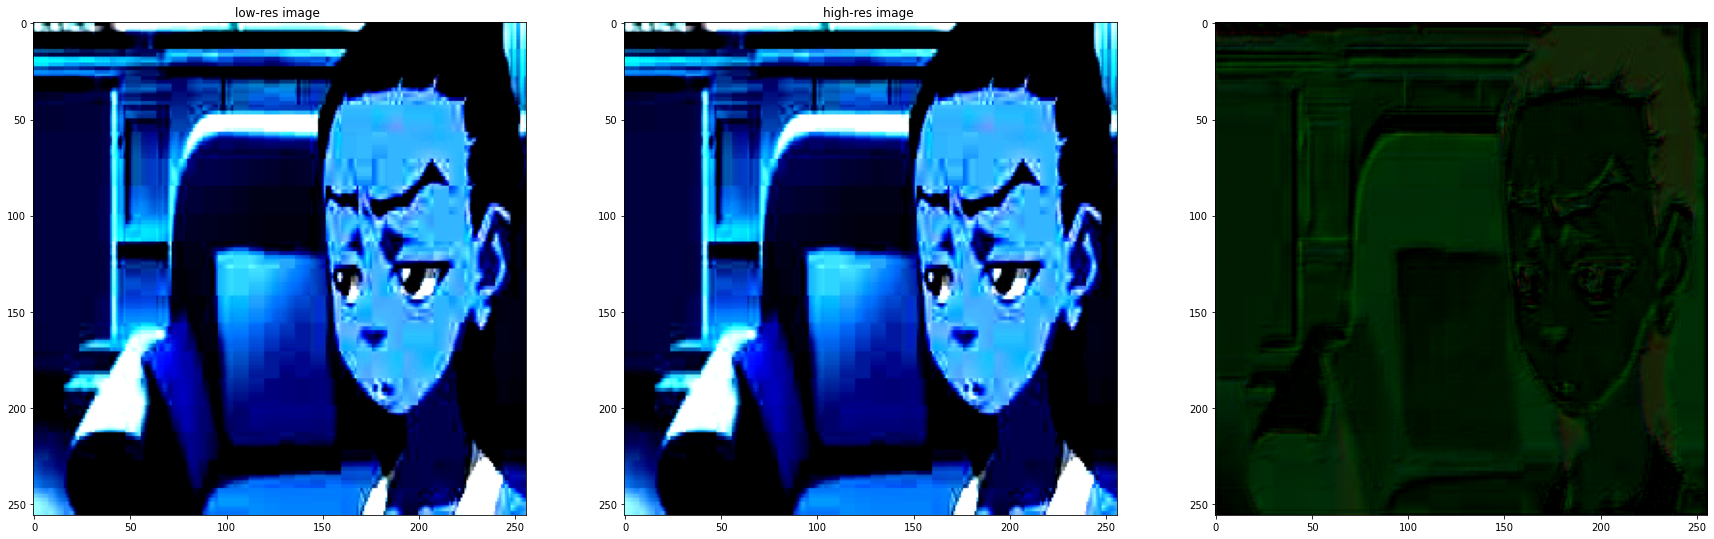

<Figure size 2880x2880 with 0 Axes>

In [105]:
predict_y_2 = model_3.predict(val_x)
#plt.subplots(2,2,figsize=(15,15))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[65])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[65])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y_2[65])

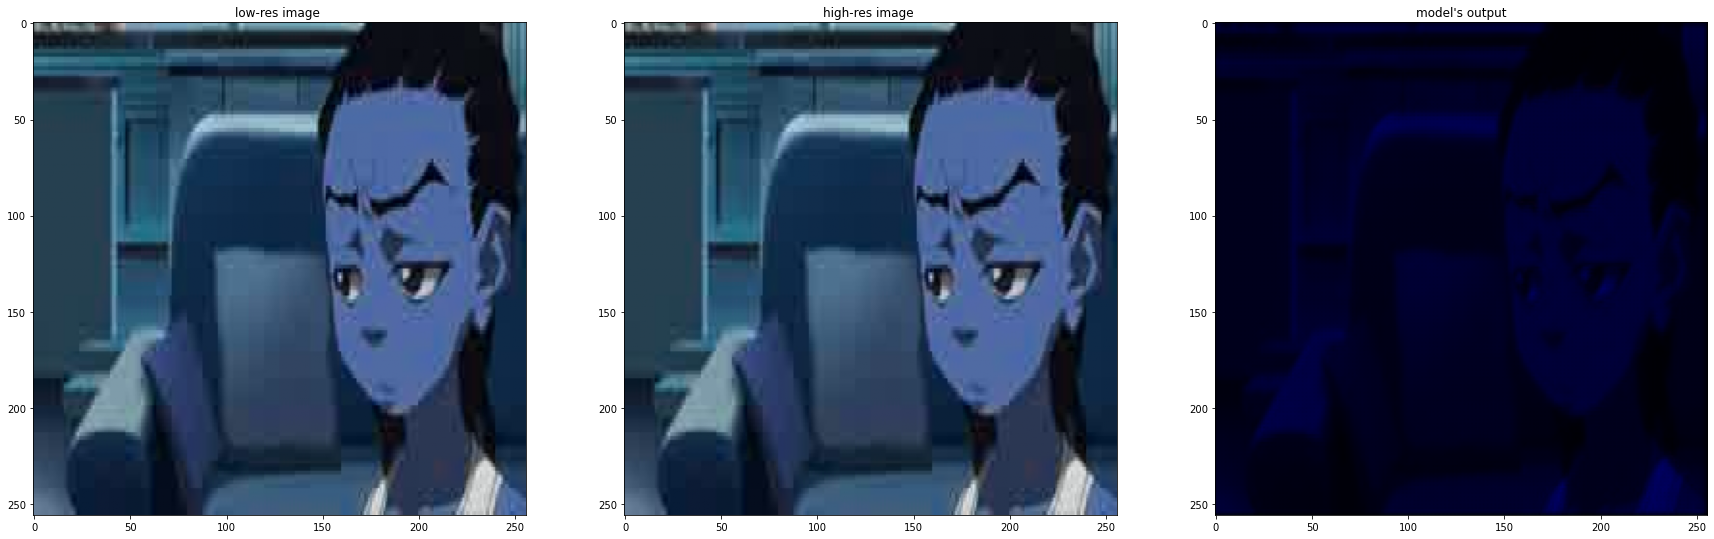

<Figure size 2880x2880 with 0 Axes>

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[69])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[69])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y_2[69])
ax3.title.set_text("model's output")

# Model with Convolution 2D Transpose

In [ ]:
# NEw model utilizing convolution 2D transpose 
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l1)

    l3 = MaxPooling2D(padding='same')(l2)
    l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l4)

    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l6)
    
    l8 = UpSampling2D()(l7)

    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l9)

    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l13)

    l15 = add([l14, l2])

    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10))(l15)


    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model



In [ ]:
## Generating a NEW architecture with BN and 
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l1)
    l3 = MaxPooling2D(padding='same')(l2)
    l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l4)
    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l6)
    
    l8 = UpSampling2D()(l7)
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l9)
    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l13)
    l15 = add([l14, l2])
    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l15)
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [ ]:
model.summary()

In [ ]:
def train(train_x, train_y, epochs = 1, batch_size = 24, shuffle = True):
    model.fit(train_x, train_y,epochs= epochs,batch_size=batch_size,shuffle=shuffle)
train(train_x, train_y, epochs = 10, batch_size = 24, shuffle = True)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l1)
    l3 = MaxPooling2D(padding='same')(l2)
    l3 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l3)
    #l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l4)
    l6 = MaxPooling2D(padding='same')(l5)
    l15 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l6)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l15)
    
    l8 = UpSampling2D()(l7)
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l9)
    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l13)
    l15 = add([l14, l2])
    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l15)
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [ ]:
model.summary()

In [ ]:
#with tf.device('/device:GPU:0'):
model = build_model()
#train_x , train_y = train_x , train_y
#val_x , val_y = val_x, val_y

In [ ]:
def train(train_x, train_y, epochs = 1, batch_size = 24, shuffle = True):
    model.fit(train_x, train_y,epochs= epochs,batch_size=batch_size,shuffle=shuffle)
train(train_x, train_y, epochs = 10, batch_size = 24, shuffle = True)